🧠 Training model...
📏 Threshold set at 0.60231
⚡ Testing inference speed...
✅ Total inference time: 23.60 ms for 9998 samples
⏱️ Average per-sample: 0.002360 ms (423.7 samples/sec)

📊 Confusion Matrix:
[[9504   96]
 [ 197  201]]

📈 Classification Report:
              precision    recall  f1-score   support

           0      0.980     0.990     0.985      9600
           1      0.677     0.505     0.578       398

    accuracy                          0.971      9998
   macro avg      0.828     0.748     0.782      9998
weighted avg      0.968     0.971     0.969      9998



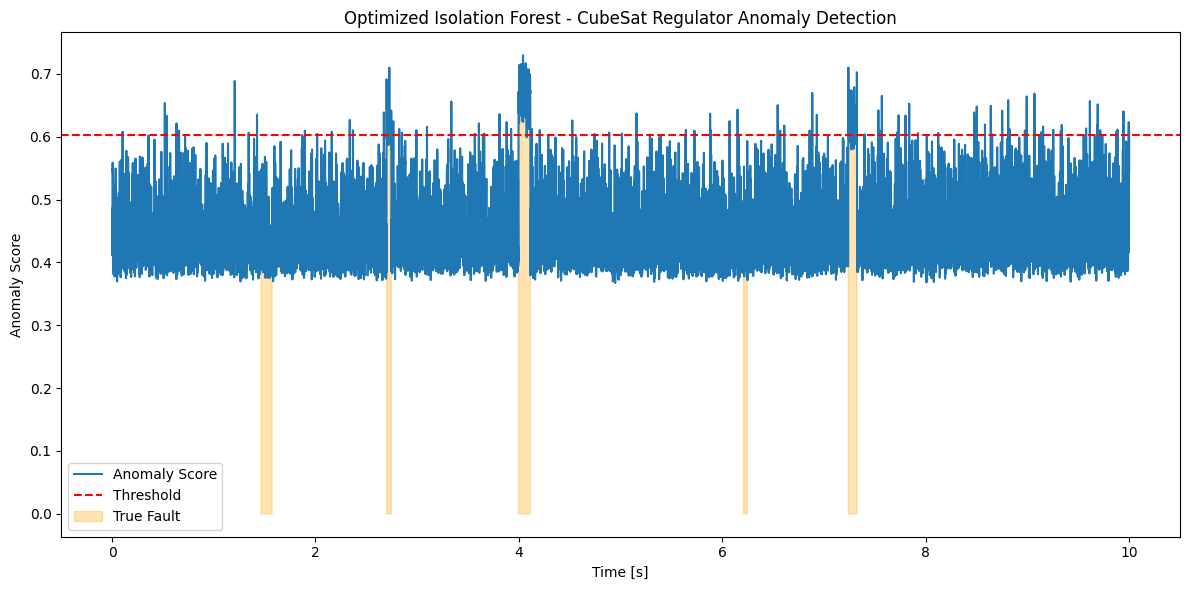


💾 Model + threshold saved to '../models/iforest_model.pkl'
🚀 Optimization complete.


In [2]:
# ============================================================
# 🚀 CubeSat Regulator Fault Detection - Optimized Isolation Forest
# ============================================================

import time
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report

# ------------------------------------------------------------
# 1️⃣ Charger les données
# ------------------------------------------------------------
df_feat = pd.read_csv("../data/cubesat_features.csv")

# Séparer données saines et fautives
healthy_df = df_feat[df_feat["fault_label"] == 0]
fault_df   = df_feat[df_feat["fault_label"] == 1]

# Extraction des features (utiliser float32 pour réduire la mémoire)
FEATURES = ["dI_dt", "Vout_droop", "ripple_RMS", "efficiency", "dEff_dT"]
X_healthy = healthy_df[FEATURES].to_numpy(dtype=np.float32, copy=False)
X_all     = df_feat[FEATURES].to_numpy(dtype=np.float32, copy=False)

# ------------------------------------------------------------
# 2️⃣ Construire un pipeline (scaling + isolation forest)
# ------------------------------------------------------------
#  Optimisations appliquées :
# - Pipeline : évite les multiples appels Python
# - n_jobs=-1 : parallélise sur tous les cœurs
# - n_estimators réduit : 50 (plus rapide)
# - max_samples=256 : arbres moins profonds
# - contamination='auto' : évite offset interne inutile
# - float32 : opérations plus rapides
# - random_state : reproductibilité

pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("iforest", IsolationForest(
        n_estimators=50,
        max_samples=256,
        contamination='auto',
        random_state=42,
        n_jobs=-1
    ))
])

# ------------------------------------------------------------
# 3️⃣ Entraînement sur données saines
# ------------------------------------------------------------
print("🧠 Training model...")
pipe.fit(X_healthy)

# ------------------------------------------------------------
# 4️⃣ Calibration du seuil
# ------------------------------------------------------------
# On utilise le 99.0 percentile des scores sur données saines
scores_healthy = -pipe.score_samples(X_healthy)
threshold = np.percentile(scores_healthy, 99.0)
print(f"📏 Threshold set at {threshold:.5f}")

# ------------------------------------------------------------
# 5️⃣ Test de performance et mesure du temps d'inférence
# ------------------------------------------------------------
print("⚡ Testing inference speed...")

# Warm-up (pour éviter coût de compilation initiale scikit-learn)
_ = pipe.score_samples(X_all[:min(1000, len(X_all))])

# Chronométrage de l’inférence complète
start = time.perf_counter()
scores = -pipe.score_samples(X_all)
end = time.perf_counter()

elapsed_s = end - start
elapsed_ms = elapsed_s * 1000
time_per_sample = elapsed_ms / len(X_all)

print(f"✅ Total inference time: {elapsed_ms:.2f} ms for {len(X_all)} samples")
print(f"⏱️ Average per-sample: {time_per_sample:.6f} ms ({1/time_per_sample:.1f} samples/sec)")

# ------------------------------------------------------------
# 6️⃣ Génération des prédictions et évaluation
# ------------------------------------------------------------
df_feat["anomaly_score"] = scores
df_feat["predicted_fault"] = (df_feat["anomaly_score"] > threshold).astype(int)

y_true = df_feat["fault_label"]
y_pred = df_feat["predicted_fault"]

print("\n📊 Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))
print("\n📈 Classification Report:")
print(classification_report(y_true, y_pred, digits=3))

# ------------------------------------------------------------
# 7️⃣ Visualisation rapide
# ------------------------------------------------------------
plt.figure(figsize=(12,6))
plt.plot(df_feat["time_s"], df_feat["anomaly_score"], label="Anomaly Score")
plt.axhline(threshold, color="red", linestyle="--", label="Threshold")
plt.fill_between(df_feat["time_s"], 0, df_feat["anomaly_score"],
                 where=df_feat["fault_label"]==1, color="orange", alpha=0.3, label="True Fault")
plt.title("Optimized Isolation Forest - CubeSat Regulator Anomaly Detection")
plt.xlabel("Time [s]")
plt.ylabel("Anomaly Score")
plt.legend()
plt.tight_layout()
plt.show()

# ------------------------------------------------------------
# 8️⃣ Sauvegarde compacte du modèle complet
# ------------------------------------------------------------
# ✅ On sauvegarde le pipeline + seuil dans un seul fichier .pkl
pack = {"pipe": pipe, "threshold": float(threshold)}
joblib.dump(pack, "../models/iforest_model.pkl")

print("\n💾 Model + threshold saved to '../models/iforest_model.pkl'")
print("🚀 Optimization complete.")
